# Filtering in Frequency Domain

## Fourier Transoform

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt

FIGSIZE = (15, 15)

### Load `pulmonaire.png` and Convert to Gray

(256, 256)

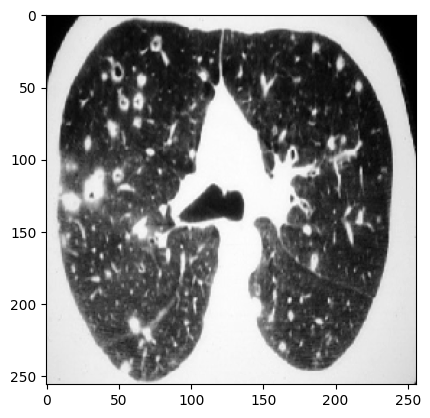

In [2]:
pulmonaire = cv2.imread("images/pulmonaire.png")
pulmonaire = cv2.cvtColor(pulmonaire, cv2.COLOR_BGR2GRAY)
plt.imshow(pulmonaire, cmap='gray')
pulmonaire.shape

### Fourier Transform 

#### Basics
[see](https://github.com/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial40_what_is_fourier_transform.py)

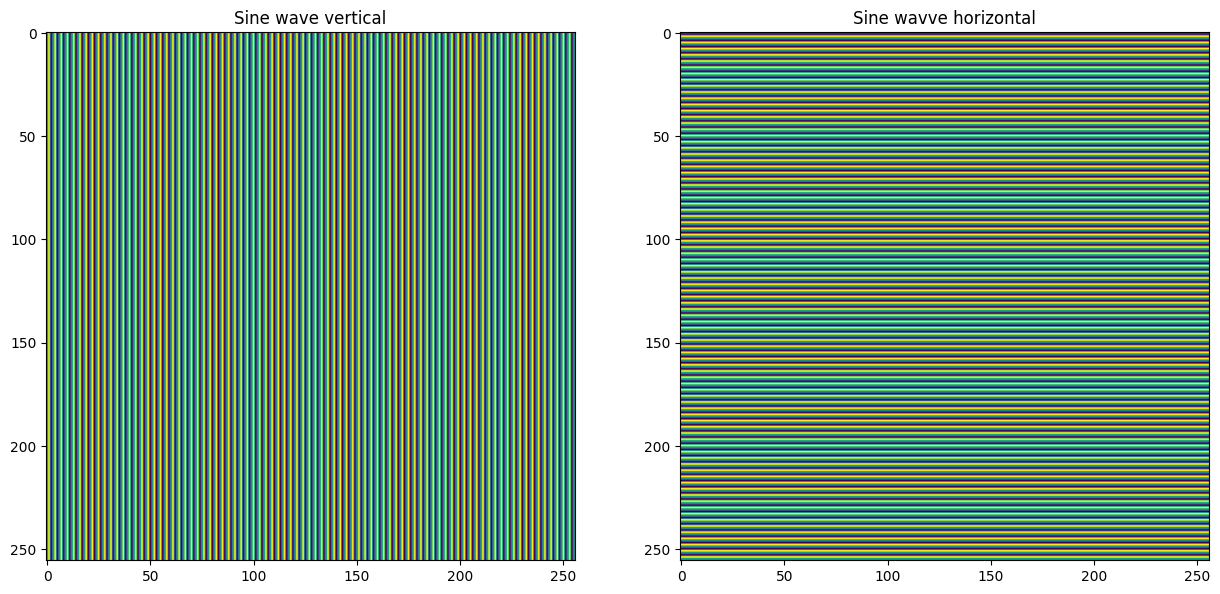

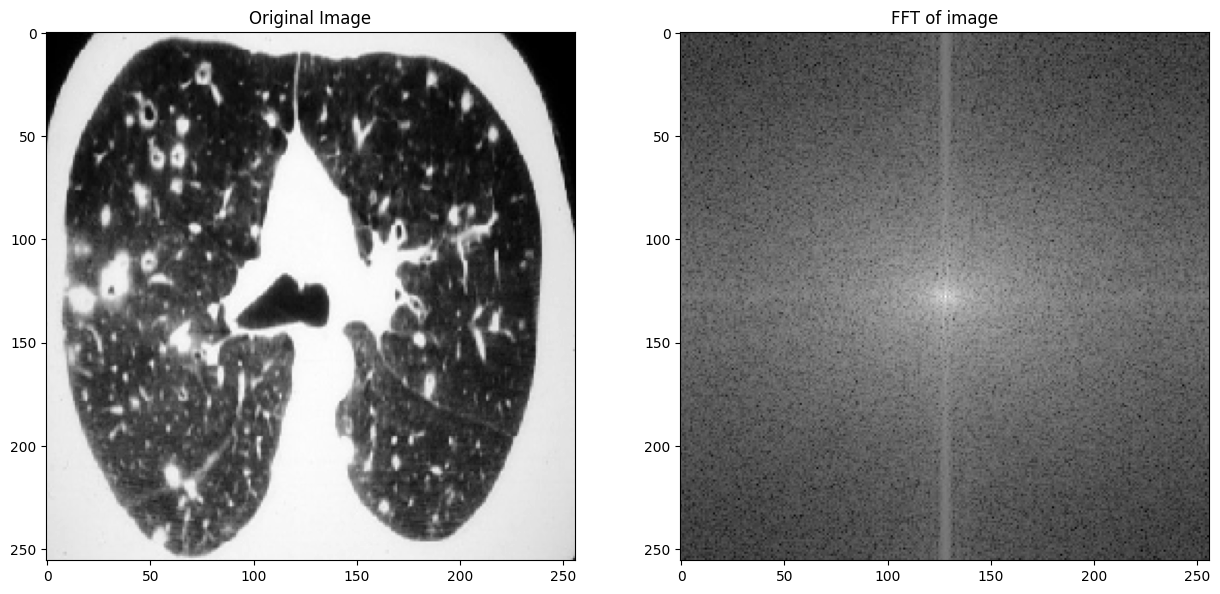

In [3]:
#Generate a 2D sine wave image
x = np.arange(256)  # Generate values from 0 to 255 (or image size)
y = np.sin(2 * np.pi * x / 3)  # Calculate the sine of x values
# Divide by a smaller number above to increase the frequency
y += max(y)

# Generate a 256x256 image (2D array of the sine wave)
sine_wave = np.array([[y[j]*127 for j in range(256)] for i in range(256)], dtype=np.uint8)
sine_wave_rot = np.rot90(sine_wave)  # Rotate img by 90 degrees

_, plots = plt.subplots(nrows=1, ncols=2, figsize=FIGSIZE)
plots[0].set_title("Sine wave vertical")
plots[0].imshow(sine_wave)
plots[1].set_title("Sine wavve horizontal")
plots[1].imshow(sine_wave_rot)
plt.show()

pulmonaire_dft = cv2.dft(np.float32(pulmonaire), flags=cv2.DFT_COMPLEX_OUTPUT)

#Without shifting the data would be centered around origin at the top left
#Shifting it moves the origin to the center of the image.
pulmonaire_dft_shift = np.fft.fftshift(pulmonaire_dft)

#Calculate magnitude spectrum from the DFT (Real part and imaginary part)
#Added 1 as we may see 0 values and log of 0 is indeterminate
magnitude_spectrum = 20 * np.log(cv2.magnitude(pulmonaire_dft_shift[:, :, 0], pulmonaire_dft_shift[:, :, 1])+1)

#As the spatial frequency increases (bars closer), 
#the peaks in the DFT amplitude spectrum move farther away from the origin

#Center represents low frequency and the corners high frequency (with DFT shift).
#To build high pass filter block center corresponding to low frequencies and let
#high frequencies go through. This is nothing but an edge filter. 

_, plots = plt.subplots(nrows=1, ncols=2, figsize=FIGSIZE)
plots[0].set_title("Original Image")
plots[0].imshow(pulmonaire, cmap='gray')
plots[1].set_title("FFT of image")
plots[1].imshow(magnitude_spectrum, cmap='gray')
plt.show()


#### Image filters using Fourier Transform

/tmp/ipykernel_101268/2081504807.py:39: RuntimeWarning: divide by zero encountered in log
  fshift_mask_mag = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))


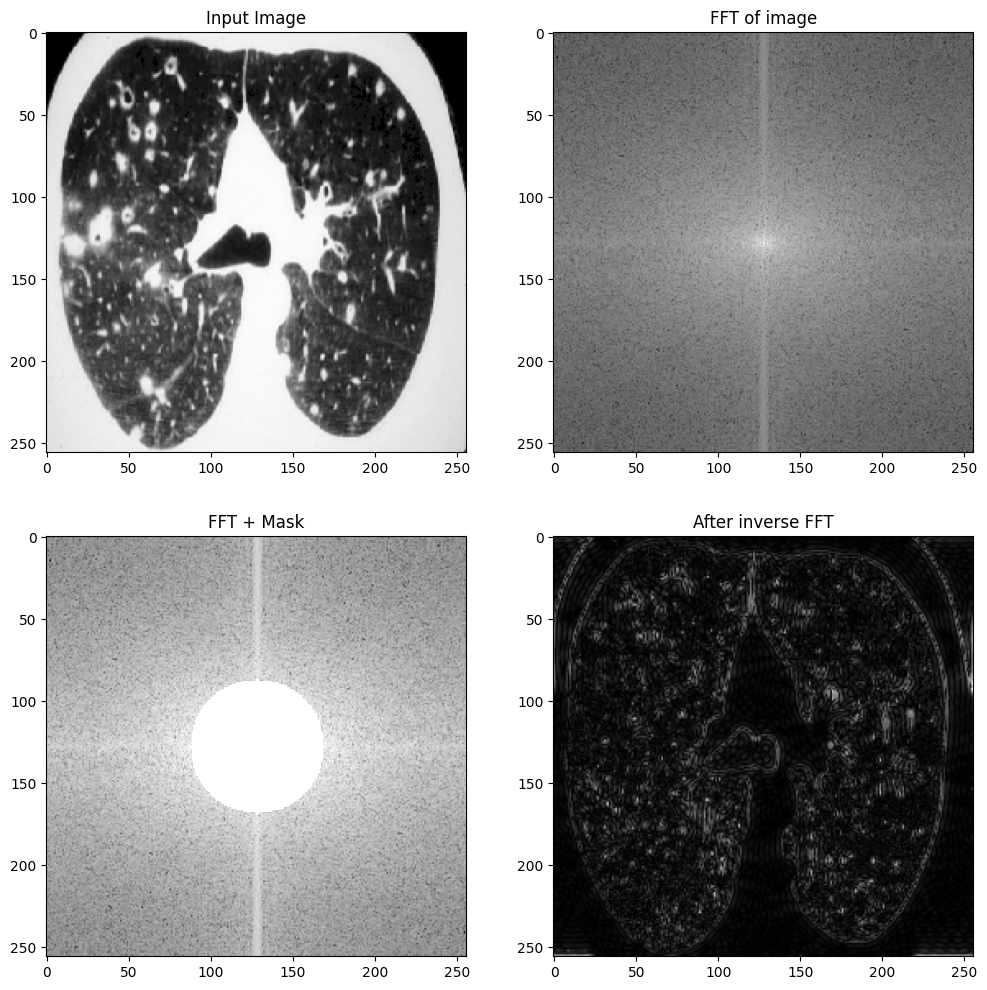

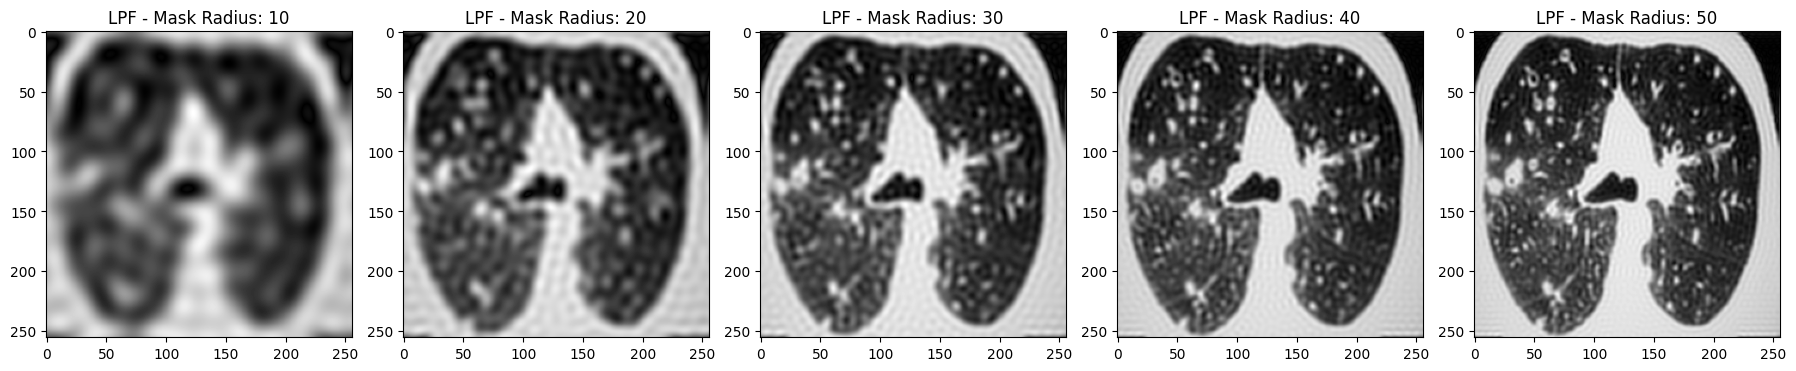

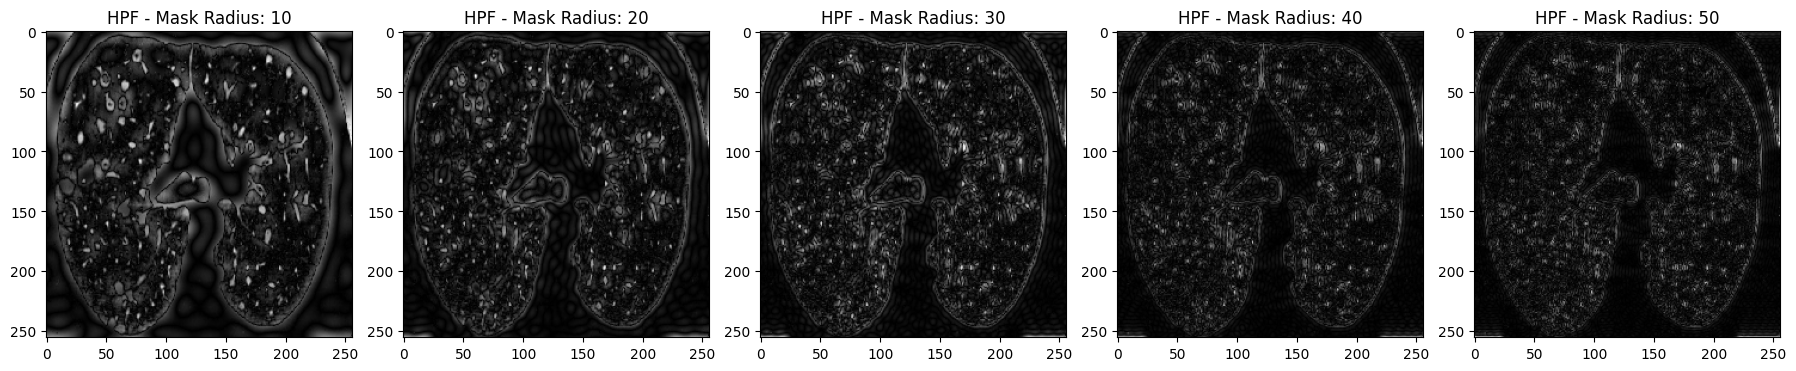

In [4]:
pulmonaire_gray = cv2.imread("images/pulmonaire.png", 0)  # 0-flag: Grayscale mode

#Output is a 2D complex array. 1st channel real and 2nd imaginary
#For fft in opencv input image needs to be converted to float32
pulmonaire_dft = cv2.dft(np.float32(pulmonaire_gray), flags=cv2.DFT_COMPLEX_OUTPUT)

pulmonaire_dft_shift = np.fft.fftshift(pulmonaire_dft)


##Magnitude of the function is 20.log(abs(f))
#For values that are 0 we may end up with indeterminate values for log. 
#So we can add 1 to the array to avoid seeing a warning. 
magnitude_spectrum = 20 * np.log(cv2.magnitude(pulmonaire_dft_shift[:, :, 0], pulmonaire_dft_shift[:, :, 1]))


# Circular HPF mask, center circle is 0, remaining all ones
#Can be used for edge detection because low frequencies at center are blocked
#and only high frequencies are allowed. Edges are high frequency components.
#Amplifies noise.

# Note: we can use other shapes than circles

rows, cols = pulmonaire_gray.shape
crow, ccol = rows // 2, cols // 2

mask = np.ones((rows, cols, 2), np.uint8)
r = 40  # Radius of the circle
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r  # Equattion of the circle
mask[mask_area] = 0


# apply mask and inverse DFT: Multiply fourier transformed image (values)
#with the mask values. 
fshift = pulmonaire_dft_shift * mask

#Get the magnitude spectrum (only for plotting purposes)
fshift_mask_mag = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))


#Inverse shift to shift origin back to top left.
f_ishift = np.fft.ifftshift(fshift)

#Inverse DFT to convert back to image domain from the frequency domain. 
#Will be complex numbers
pulmonaire_back = cv2.idft(f_ishift)

# Magnitude spectrum of the image domain
pulmonaire_back = cv2.magnitude(pulmonaire_back[:, :, 0], pulmonaire_back[:, :, 1])


def create_circular_mask_high_pass(shape, radius):
  """Create a high pass filter circular mask

  Args:
      shape (tuple): The shape of the original image in gray scale
      radius (int): The radius of the circular mask

  Returns:
      np.array of the given shape
  """
  rows, cols = shape
  crow, ccol = rows // 2, cols // 2
  mask = np.ones((rows, cols, 2), np.uint8)
  r = radius  # Radius of the circle
  center = [crow, ccol]
  x, y = np.ogrid[:rows, :cols]
  mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r  # Equattion of the circle
  mask[mask_area] = 0
  return mask

def create_circular_mask_low_pass(shape, radius):
  """Create a low pass filter circular mask

  Args:
      shape (tuple): The shape of the original image in gray scale
      radius (int): The radius of the circular mask

  Returns:
      np.array of the given shape
  """
  rows, cols = shape
  crow, ccol = rows // 2, cols // 2
  mask = np.zeros((rows, cols, 2), np.uint8)
  r = radius  # Radius of the circle
  center = [crow, ccol]
  x, y = np.ogrid[:rows, :cols]
  mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r  # Equattion of the circle
  mask[mask_area] = 1
  return mask

def fourier_transform_filter(img_gray, mask):
  img_dft = cv2.dft(np.float32(img_gray), flags=cv2.DFT_COMPLEX_OUTPUT)
  img_dft_shift = np.fft.fftshift(img_dft)
  
  # Apply the mask
  fshift = img_dft_shift * mask
  
  #Inverse shift to shift origin back to top left.
  f_ishift = np.fft.ifftshift(fshift)
  img_back = cv2.idft(f_ishift)
  # Magnitude spectrum of the image domain
  img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
  
  return img_back


fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(pulmonaire_gray, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(magnitude_spectrum, cmap='gray')
ax2.title.set_text('FFT of image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(fshift_mask_mag, cmap='gray')
ax3.title.set_text('FFT + Mask')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(pulmonaire_back, cmap='gray')
ax4.title.set_text('After inverse FFT')
plt.show()

# Low pass filters
_, plots = plt.subplots(nrows=1, ncols=5, figsize=(18, 12))
radius = (10, 20, 30, 40, 50)
for i, r in zip(range(5), radius):
  mask = create_circular_mask_low_pass(pulmonaire_gray.shape, r)
  filterd = fourier_transform_filter(pulmonaire_gray, mask)
  plots[i].set_title(f"LPF - Mask Radius: {r}")
  plots[i].imshow(filterd, cmap='gray')
plt.tight_layout()
plt.show()


# High pass filters
_, plots = plt.subplots(nrows=1, ncols=5, figsize=(18, 12))
radius = (10, 20, 30, 40, 50)
for i, r in zip(range(5), radius):
  mask = create_circular_mask_high_pass(pulmonaire_gray.shape, r)
  filterd = fourier_transform_filter(pulmonaire_gray, mask)
  plots[i].set_title(f"HPF - Mask Radius: {r}")
  plots[i].imshow(filterd, cmap='gray')
plt.tight_layout()
plt.show()
  

# TODO: encapsulate the fourier transform into a function

## Wavelet Transform for Image Compression - Very powerful in terms of showing the details
Wavelet Transform provides a multi-resolution analysis of an image. It decomposes the image into approximation and detail coefficients, allowing for efficient compression. [ref](https://medium.com/@ryanwmccoy/exploring-image-compression-with-fourier-and-wavelet-transformations-using-python-0b3c15a72703)

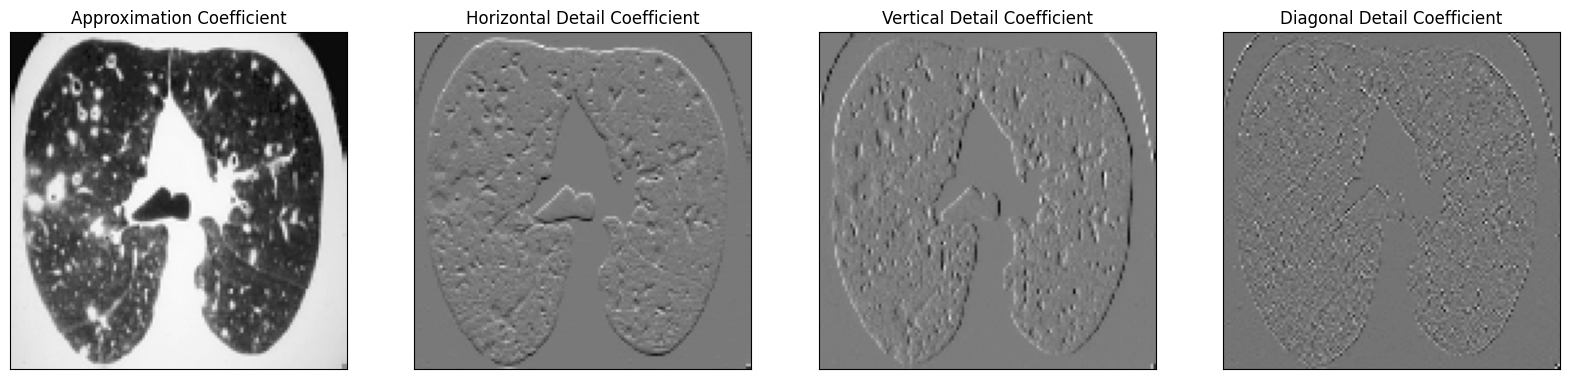

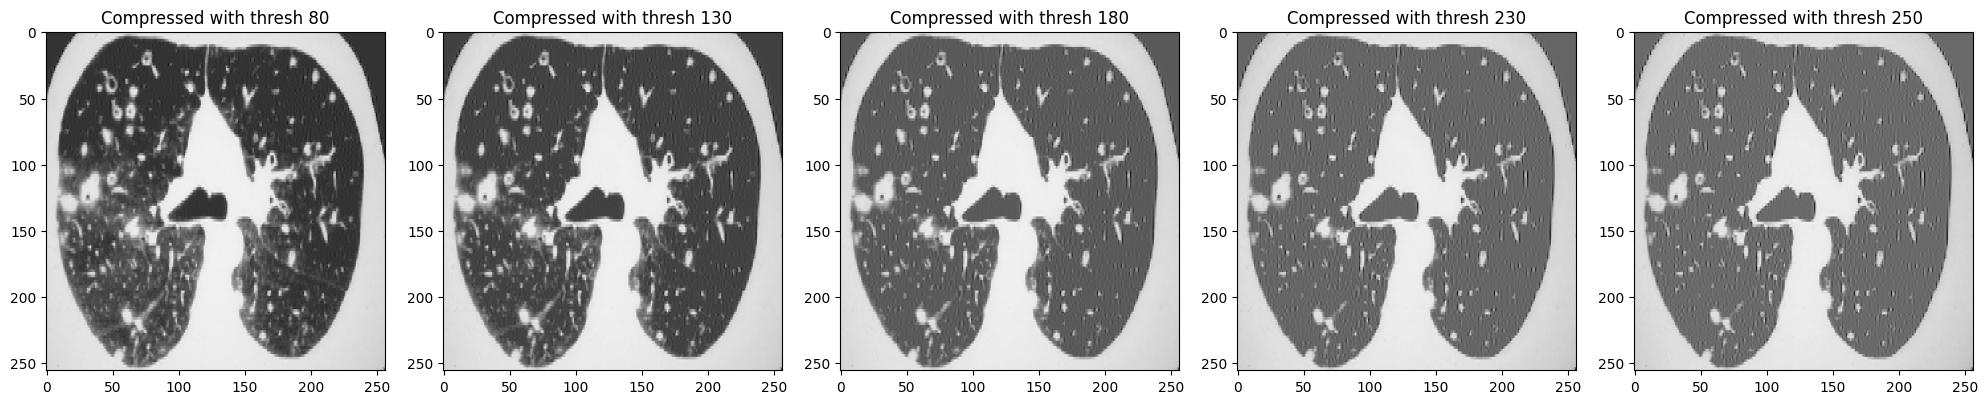

In [5]:
pulmonaire_gray = cv2.imread("images/pulmonaire.png", 0)

# Find the coefficients
coeffs = pywt.dwt2(pulmonaire_gray, 'bior1.3')
cA, (cH, cV, cD) = coeffs

# Plot the Coefficients
plt.figure(figsize=(20, 15))
plt.subplot(141), plt.imshow(cA, cmap='gray')
plt.title('Approximation Coefficient'), plt.xticks([]), plt.yticks([])
plt.subplot(142), plt.imshow(cH, cmap='gray')
plt.title('Horizontal Detail Coefficient'), plt.xticks([]), plt.yticks([])
plt.subplot(143), plt.imshow(cV, cmap='gray')
plt.title('Vertical Detail Coefficient'), plt.xticks([]), plt.yticks([])
plt.subplot(144), plt.imshow(cD, cmap='gray')
plt.title('Diagonal Detail Coefficient'), plt.xticks([]), plt.yticks([])
plt.show()


## Applying the compression

def apply_wavelet_compression(img_gray, threshold):
  coeffs = pywt.dwt2(img_gray, 'bior1.3')
  cA, (cH, cV, cD) = coeffs

  # Using the thresholoding limit for the wavelete transform
  cA_thresholded = pywt.threshold(cA, threshold, mode='soft')
  cH_thresholded = pywt.threshold(cH, threshold, mode='soft')

  #Compress the image
  coeffs_thresholded = (cA_thresholded, (cH_thresholded, cV, cD))
  img_compressed = pywt.idwt2(coeffs_thresholded, 'bior1.3')
  return img_compressed

# Show the resulting image after compression
_, plots = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))
thresholds = (80, 130, 180, 230, 250)
for i, t in zip(range(5), thresholds):
  img_compressed = apply_wavelet_compression(pulmonaire_gray, t)  
  plots[i].set_title(f"Compressed with thresh {t}")
  plots[i].imshow(img_compressed, cmap='gray')
plt.tight_layout()
plt.show()


## Segment image using K-Means
[ref](https://medium.com/towardssingularity/k-means-clustering-for-image-segmentation-using-opencv-in-python-17178ce3d6f3)

[[ 55]
 [ 55]
 [ 55]
 ...
 [215]
 [215]
 [ 55]]


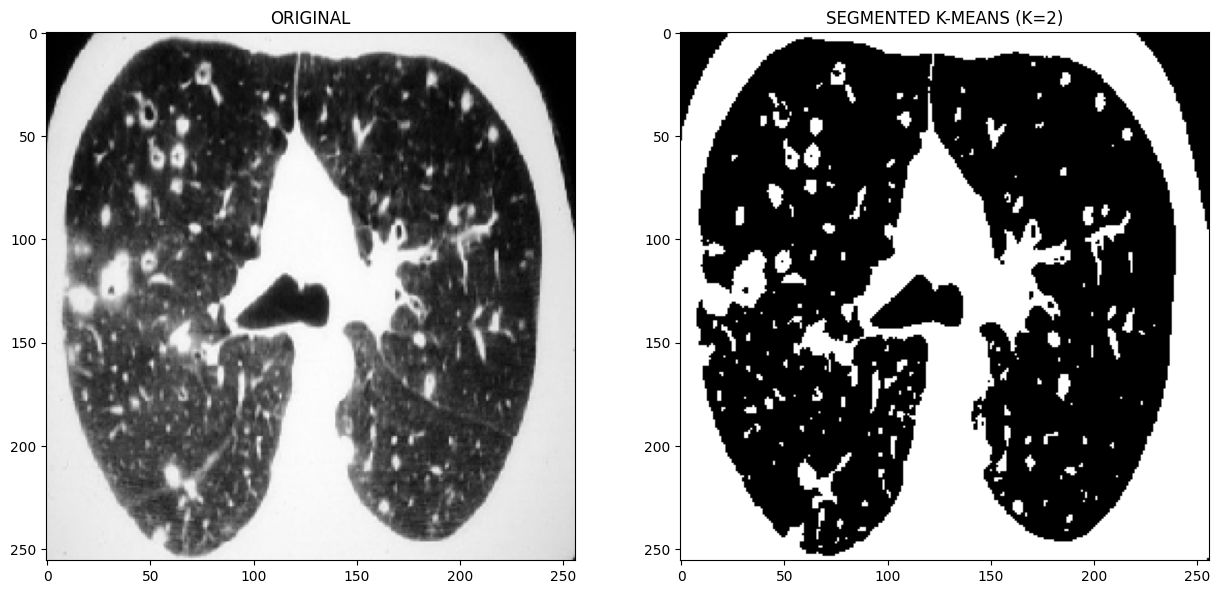

In [6]:
pulmonaire_gray = cv2.imread("images/pulmonaire.png", 0)
#pulmonaire = cv2.cvtColor(pulmonaire, cv2.COLOR_BGR2RGB)

# Reshaping the image into a 2D array of pixels and 3 color values (RGB) 
#pixels_val = pulmonaire.reshape((-1, 3))

# Reshaping the image into an array of pixels
pixels_val = pulmonaire_gray.reshape((-1, 1))


# Convert to float type only for supporting cv2.kmean
pixels_val = np.float32(pixels_val)

# criteria
criteria = (cv2.TermCriteria_EPS + cv2.TermCriteria_MAX_ITER, 100, 0.85)

# Nunber of clusters
k = 2

retval, labels, centers = cv2.kmeans(pixels_val, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)


# convert data into 8-bit values
centers = np.uint8(centers)

segmented_data = centers[labels.flatten()]  # Mapping lables to center points (RGB Value)

# reshape data into the original image dimensions 
pulmonaire_segmented = segmented_data.reshape((pulmonaire_gray.shape))

plt.figure(figsize=FIGSIZE)
plt.subplot(1, 2, 1)
plt.title("ORIGINAL")
plt.imshow(pulmonaire, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("SEGMENTED K-MEANS (K=2)")
plt.imshow(pulmonaire_segmented, cmap='gray')

### Correct the image using erosion and and dilation

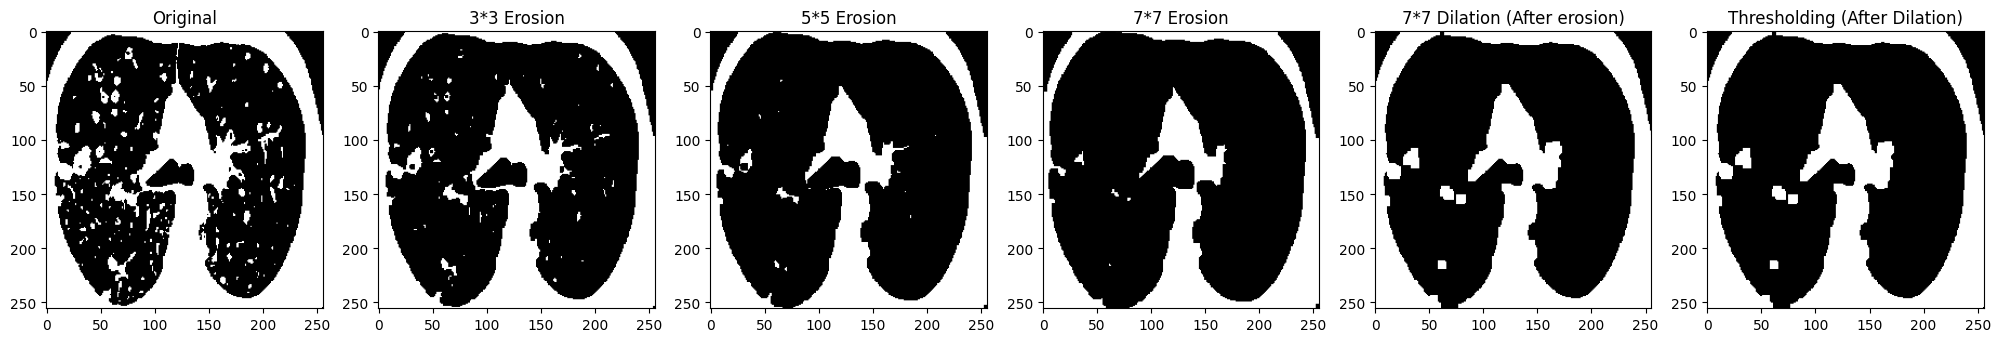

In [7]:
kernel_3_by_3 = np.ones((3, 3), np.uint8)
kernel_5_by_5 = np.ones((5, 5), np.uint8)
kernel_7_by_7 = np.ones((7, 7), np.uint8)
lung_erosion_3_by_3 = cv2.erode(pulmonaire_segmented, kernel_3_by_3, iterations=1)
lung_erosion_5_by_5 = cv2.erode(pulmonaire_segmented, kernel_5_by_5, iterations=1)
lung_erosion_7_by_7 = cv2.erode(pulmonaire_segmented, kernel_7_by_7, iterations=1)
lung_dilation_7_by_7 = cv2.dilate(lung_erosion_7_by_7, kernel_7_by_7, iterations=1)
(_, im_bw_otsu) = cv2.threshold(lung_dilation_7_by_7, 10, 255, cv2.THRESH_OTSU)


## DISPLAYING ##
_, plots = plt.subplots(nrows=1, ncols=6, figsize=(25, 15))
plots[0].set_title("Original")
plots[0].imshow(pulmonaire_segmented, cmap='gray')
plots[1].set_title("3*3 Erosion")
plots[1].imshow(lung_erosion_3_by_3, cmap='gray')
plots[2].set_title("5*5 Erosion")
plots[2].imshow(lung_erosion_5_by_5, cmap='gray')
plots[3].set_title("7*7 Erosion")
plots[3].imshow(lung_erosion_7_by_7, cmap='gray')
plots[4].set_title("7*7 Dilation (After erosion)")
plots[4].imshow(lung_dilation_7_by_7, cmap='gray')
plots[5].set_title("Thresholding (After Dilation)")
plots[5].imshow(im_bw_otsu, cmap='gray')
plt.show()